## Training notebook for DDPM model for mitosis inpainting



In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL, DDPMPipeline
from accelerate import Accelerator
from tqdm import tqdm
import wandb
from torch_ema import ExponentialMovingAverage

In [ ]:

import albumentations as A
import numpy as np
from tiatoolbox.tools.stainaugment import StainAugmentor
from albumentations.pytorch import ToTensorV2

stain_matrix = np.array([[0.91633014, -0.20408072, -0.34451435],
               [0.17669817, 0.92528011, 0.33561059]])

class HistologyInpaintingDataset(Dataset):
    """
    - target_image: the full, unmasked image (128x128).
    - masked_image: same image but central region zeroed out (conditioning).
    - binary_mask: single-channel mask from disk (conditioning).
    """
    def __init__(self, image_folder, mask_folder, image_size=(128, 128)):
        super().__init__()
        self.image_size = image_size
        
        self.image_paths = sorted(
            os.path.join(image_folder, f)
            for f in os.listdir(image_folder)
            if f.endswith('.png')
        )
        self.mask_paths = sorted(
            os.path.join(mask_folder, f)
            for f in os.listdir(mask_folder)
            if f.endswith('.png')
        )
        
        self.transform = A.Compose([
                        A.RandomRotate90(),
                        A.HorizontalFlip(0.5),
                        A.VerticalFlip(0.5),
                        StainAugmentor(method='macenko', stain_matrix=stain_matrix),
                        A.RandomBrightnessContrast(p=0.2),
                        ToTensorV2(),
                        ])
        
        self.hole_size = 64
        self.H, self.W = image_size
        self.y_start = self.H // 2 - self.hole_size // 2
        self.x_start = self.W // 2 - self.hole_size // 2
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        target_image = Image.open(self.image_paths[idx]).convert("RGB")
        
        binary_mask = Image.open(self.mask_paths[idx]).convert("L")

        transformed = self.transform(image=np.array(target_image), mask=np.array(binary_mask))
        target_image = transformed['image'].float()/255.
        binary_mask = transformed['mask'].float()/255.
        
        masked_image = target_image.clone()
        masked_image[
            :,
            self.y_start : self.y_start + self.hole_size,
            self.x_start : self.x_start + self.hole_size
        ] = 0.0
        
        return {
            "target_image": target_image,
            "masked_image": masked_image,
            "binary_mask":  binary_mask[None,:,:]
        }



class DiffusionInpaintingModel(nn.Module):
    """
    A UNet2DConditionModel that predicts noise, conditioned on:
      - masked_image (3-channel)
      - binary_mask (1-channel)
    """
    def __init__(self, cross_attention_dim=512):
        super().__init__()
        #self.condition_embedder = DualConditionEmbedder(embed_dim=cross_attention_dim)
        
        #self.embed_proj = nn.Linear(8, 512)  # or higher
        self.unet = UNet2DConditionModel(
            sample_size=128,
            in_channels=7,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(128, 256, 256, 256),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
            cross_attention_dim=cross_attention_dim,
        )
        
    def forward(self, noised_image, timesteps, masked_image, binary_mask):
        # Produce cross-attention tokens from condition
        #conditioning_tokens = self.condition_embedder(masked_image, binary_mask)
        
        #conditioning_tokens = self.embed_proj(conditioning_tokens)        

        # UNet forward pass (predict noise)
        return self.unet(
            sample=torch.cat((noised_image, masked_image, binary_mask), dim=1),
            timestep=timesteps,
            encoder_hidden_states=torch.zeros(noised_image.shape[0],1,1).to(self.unet.device)
        ).sample




@torch.no_grad()
def sample_with_model(model, scheduler, masked_image, binary_mask, batch_size=4):
   
   # Given a batch of masked_images + binary_masks, generate samples from pure noise using the diffusion model in an iterative manner (DDPM sampling).
   
    device = masked_image.device
    shape = masked_image.shape  # (B, 3, 128, 128)

    # Start from standard normal noise: x_T ~ N(0, I)
    sample = torch.randn(shape, device=device)
    
    # Run the iterative process over all timesteps
    for t in scheduler.timesteps:
        # Predict noise at step t: eps_theta(x_t, t)
        model_output = model(sample, t, masked_image, binary_mask)
        # Use the scheduler to get the previous sample x_{t-1}
        sample = scheduler.step(model_output, t, sample).prev_sample
    
    sample = torch.clamp(sample, 0.0, 1.0)
    return sample


def train_inpainting(
    image_folder, 
    mask_folder, 
    epochs=5, 
    batch_size=4, 
    lr=1e-4, 
    p_drop=0.1,
    num_train_timesteps=1000,
    val_split=0.2
):
    full_dataset = HistologyInpaintingDataset(image_folder, mask_folder, (128, 128))
    total_len = len(full_dataset)
    val_len = int(val_split * total_len)
    train_len = total_len - val_len
    
    train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=8)
    
    model = DiffusionInpaintingModel(cross_attention_dim=1)
    noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

    start_epoch=1
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    accelerator = Accelerator()

    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )
    
    ema = ExponentialMovingAverage(model.parameters(), decay=0.999)

    best_val_loss = float("inf")
    best_model_path = "best_inpainting_diffusion_model_cfg_ema_l1_512_emb8_longtrain.pth"

    

    def validate_model(epoch:int):
        model.eval()
        # Load EMA weights
        ema.store(model.parameters())
        ema.copy_to(model.parameters())

        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                
                target_image = batch["target_image"].to(accelerator.device)
                masked_image = batch["masked_image"].to(accelerator.device)
                binary_mask  = batch["binary_mask"].to(accelerator.device)
                
                B = target_image.size(0)
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, 
                    (B,), device=target_image.device
                ).long()
                                        
                noise = torch.randn_like(target_image)
                noised_image = noise_scheduler.add_noise(target_image, noise, timesteps)

                pred_noise = model(noised_image, timesteps, masked_image, binary_mask)
                loss = F.l1_loss(pred_noise, noise)
                val_losses.append(loss.item())

        avg_val_loss = sum(val_losses) / len(val_losses)

        if (epoch%5==0) and (len(val_loader) > 0):
            sample_batch = next(iter(val_loader))
            sample_masked = sample_batch["masked_image"].to(accelerator.device)
            sample_bmask  = sample_batch["binary_mask"].to(accelerator.device)
            sample_target = sample_batch["target_image"].to(accelerator.device)

            n_log = min(sample_masked.size(0), 4)
            sample_masked = sample_masked[:n_log]
            sample_bmask  = sample_bmask[:n_log]
            sample_target = sample_target[:n_log]

            gen_images = sample_with_model(model, noise_scheduler, sample_masked, sample_bmask, batch_size=n_log)
            
            gen_images_cond_ctx = sample_with_model(model, noise_scheduler, sample_masked, torch.zeros_like(sample_bmask), batch_size=n_log)
            
            sample_bmask_rgb = sample_bmask.expand(-1, 3, -1, -1)
            viz_grid = make_grid(
                torch.cat([sample_masked, sample_bmask_rgb, gen_images, gen_images_cond_ctx, sample_target], dim=0),
                nrow=n_log
            )
            wandb.log({"val_samples_ema": [wandb.Image(viz_grid, caption="masked | mask | generated (all cond) | generated (ctx cond) | target")],
                      'gen_images_mean_ema': gen_images.mean(), 'sample_target_meam': sample_target.mean()})

        # Restore original (non-EMA) params
        ema.restore(model.parameters())

        if (epoch%5==0):         
            gen_images = sample_with_model(model, noise_scheduler, sample_masked, sample_bmask, batch_size=n_log)

            sample_bmask_rgb = sample_bmask.expand(-1, 3, -1, -1)
            viz_grid = make_grid(
                torch.cat([sample_masked, sample_bmask_rgb, gen_images, sample_target], dim=0),
                nrow=n_log
            )
            wandb.log({"val_samples": [wandb.Image(viz_grid, caption="masked | mask | generated | target")]})
        
        model.train()
        return avg_val_loss


    for epoch in range(epochs):
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for batch in progress_bar:
            target_image = batch["target_image"].to(accelerator.device)
            masked_image = batch["masked_image"].to(accelerator.device)
            binary_mask  = batch["binary_mask"].to(accelerator.device)
            
            B = target_image.size(0)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, 
                (B,), device=target_image.device
            ).long()
            
            noise = torch.randn_like(target_image)
            noised_image = noise_scheduler.add_noise(target_image, noise, timesteps)

            # Drop condition to enable CFG
            context_conditioning = torch.rand(B, device=target_image.device) > p_drop
            masked_image = masked_image * context_conditioning.view(B, 1, 1, 1)

            mask_conditioning = torch.rand(B, device=target_image.device) > p_drop
            binary_mask  = binary_mask * mask_conditioning.view(B, 1, 1, 1)

            pred_noise = model(noised_image, timesteps, masked_image, binary_mask)

            loss = F.mse_loss(pred_noise, noise)
            
            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            
            # EMA update after optimizer step
            ema.update(model.parameters())
            
            if accelerator.is_main_process:
                wandb.log({"train_loss": loss.item(), "epoch": epoch + 1})
                
                if random.random() < 0.01:
                    quick_denoise = noised_image - pred_noise
                    quick_denoise = torch.clamp(quick_denoise, 0, 1)

                    bmask_rgb = binary_mask.expand(-1, 3, -1, -1)
                    
                    n_log_img = min(B, 2)
                    log_grid = make_grid(
                        torch.cat([
                            masked_image[:n_log_img],
                            bmask_rgb[:n_log_img],
                            quick_denoise[:n_log_img],
                            target_image[:n_log_img]
                        ], dim=0),
                        nrow=n_log_img
                    )
                    wandb.log({"train_samples_one_step": [wandb.Image(log_grid)]})

        if accelerator.is_main_process:
            val_loss = validate_model(epoch)
            wandb.log({"val_loss": val_loss, "epoch": epoch + 1})
            print(f"Validation Loss at epoch {epoch+1}: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                ema.store(model.parameters())
                ema.copy_to(model.parameters())

                torch.save(model.state_dict(), best_model_path)
                print(f"New best model (EMA weights) saved at epoch {epoch+1} with val_loss={val_loss:.4f}")

                # Restore current training params
                ema.restore(model.parameters())

    wandb.finish()

In [3]:
image_folder="../../datasets/AMi-Br/Train/Images/All/"
mask_folder="../../datasets/AMi-Br/Train/Masks/All/"

In [ ]:
    

wandb.init(project="histology-inpainting", name="diffusion-inpainting-128x128-EMA-L1-DirectInputs-AmiBr-Aug")

if __name__ == "__main__":
    train_inpainting(
        image_folder=image_folder,
        mask_folder=mask_folder,
        epochs=1000,
        batch_size=4,
        lr=1e-4,
        num_train_timesteps=1000,
        val_split=0.2
    )


## Inference

In [26]:
previous_state = 'DDPM_model_weights.pth'
image_size=(128,128)
device='cuda'

model = DiffusionInpaintingModel(cross_attention_dim=1)
model.load_state_dict(torch.load(previous_state, weights_only=True))
model=model.to(device)
model.eval()
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

def get_mask_and_context():
    image = random.choice(os.listdir(image_folder))
    mask = random.choice(os.listdir(mask_folder))
    
    image_transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
            ])
    
    mask_transform = transforms.Compose([
                transforms.ToTensor()])
    
    target_image = Image.open(image_folder+os.sep+image).convert("RGB")
    target_image = image_transform(target_image)
            
    binary_mask = Image.open(mask_folder+os.sep+mask).convert("L")
    binary_mask = mask_transform(binary_mask)
            
    masked_image = target_image.clone()
    masked_image[
        :,
        32 : 32+64,
        32 : 32+64
    ] = 0.0
    return masked_image, binary_mask


masked_image,binary_mask = get_mask_and_context()
def sample_with_model_with_intermediate_results(model, scheduler, masked_image, binary_mask, batch_size=4):
   
   # Given a batch of masked_images + binary_masks, generate samples from pure noise using the diffusion model in an iterative manner (DDPM sampling).

    with torch.no_grad():
        device = masked_image.device
        shape = masked_image.shape  # (B, 3, 128, 128)
    
        # Start from standard normal noise: x_T ~ N(0, I)
        sample = torch.randn(shape, device=device)
        images=[]
        # Run the iterative process over all timesteps
        for t in tqdm(scheduler.timesteps):
            # Predict noise at step t: eps_theta(x_t, t)
            model_output = model(sample, t, masked_image, binary_mask)
            # Use the scheduler to get the previous sample x_{t-1}
            sample = scheduler.step(model_output, t, sample).prev_sample
            if (t % 20 == 0):
                images.append(sample.cpu())
        sample = torch.clamp(sample, 0.0, 1.0)
        return sample, images



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.505303..4.4949365].


(-0.5, 651.5, 261.5, -0.5)

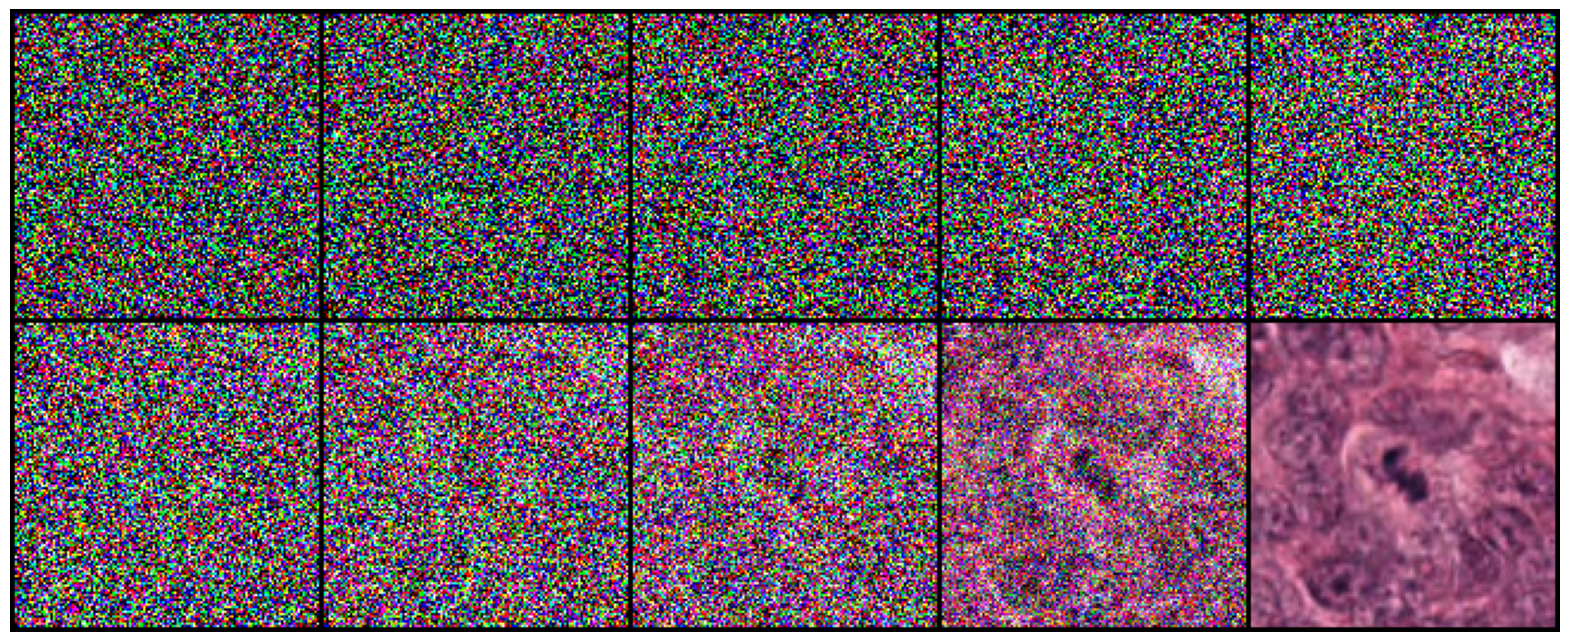

In [36]:
created = sample_with_model_with_intermediate_results(model, noise_scheduler, masked_image[None,:,:,:].to(device), binary_mask[None,:,:].to(device))
import matplotlib.pyplot as plt
viz_grid = make_grid(
            torch.cat(created[1][4::5], dim=0), nrow=5          )

plt.figure(figsize=(20,10))
plt.imshow(viz_grid.permute(1,2,0))
plt.axis('off')